In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable as V
import math
import numpy as np
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from utils import scale_fn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import logging
import sys
from argparse import ArgumentParser
import time

In [12]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class Layer(nn.Module):
    def __init__(self, n_in, n_out, layer_index):
        super(Layer, self).__init__()
        
        self.conv1 = nn.Conv2d(n_in, n_out, kernel_size=3,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_out)   
        self.layer_index = layer_index
        # If the layer is being trained or not
        self.active = True
            
    def forward(self, x):
        if not self.active:
            self.eval()
        out = F.relu(self.bn1(self.conv1(x)))
        if self.active:
            return out
        else:
            return out.detach()
        
class VGG(nn.Module):

    def __init__(self, num_classes=1000):
        super(VGG, self).__init__()
        self.layer_index = 0
        self.features = self.make_layers(cfgs['E'])   
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        self.classifier.layer_index = self.layer_index
        #self.classifier.active = True
        self._initialize_weights()
        #         # Optimizer
        # self.optim = optim.SGD([{'params':m.parameters(), 'lr':m.lr, 'layer_index':m.layer_index} for m in self.modules() if hasattr(m,'active')],  
        #                  nesterov=True,momentum=0.9, weight_decay=1e-4)

    def forward(self, x,start_layer):
        for i, layer in enumerate(self.features):
            if isinstance(layer, Layer) and layer.layer_index < start_layer:
                layer.eval()
                layer.active = False   
                layer.requires_grad_(False)     
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.log_softmax(self.classifier(x))
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
            # Set the layerwise scaling and annealing parameters
            if hasattr(m,'active'):
                # m.lr_ratio = scale_fn[self.how_scale](self.t_0 + (1 - self.t_0) * float(m.layer_index) / self.layer_index)
                # m.max_j = self.epochs * 400 * m.lr_ratio       
                # # Optionally scale the learning rates to have the same total
                # # distance traveled (modulo the gradients).
                m.lr = 0.1


    def make_layers(self,cfg):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [Layer(in_channels,v,self.layer_index)]
                self.layer_index += 1
                in_channels = v
        return nn.Sequential(*layers)



In [13]:
from utils import get_data_loader, MetricsLogger, progress
batch_size = 50
epochs = 15
losses = []
times = []
num_layer=[]#冻结层数随着epoch的变化
#用于画图
# Get information specific to each dataset
net=VGG(10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
train_loader,test_loader = get_data_loader(10, True,True, batch_size)
no_decay = ['bias', 'gamma', 'beta']
optimizer_parameters = [
        {'params': [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
        ]
optimizer = optim.SGD(optimizer_parameters, lr=0.01, momentum=0.9, weight_decay=1e-4)
start_layer = 0
grad_tensor_dict = {}#存放梯度
for name, param in net.named_parameters():  
    #print(name,param.shape)
    if "features" in name:
        grad_tensor_dict[name] = torch.zeros(param.shape).to(device)

current_grad_dict = {}
prev_intermediate_grad_dict = None
for epoch in range(0, epochs):
    start_time = time.time()
    #tr_loss = 0
    # Prepare the training data
    batches = progress(
        train_loader, desc='Epoch %d/%d, Batch ' % (epoch + 1, epochs),
        total=len(train_loader.dataset) // batch_size)
            
    step=0 #每450个batch更新一次梯度
    train_loss = []#用来画图
    # Execute training pass
    for x, y in batches:     
        #train_loss.append(train_fn(x, y))
        x = x.to(device)
        y = y.to(device)
        step += 1
        net.train() 
        optimizer.zero_grad()
        output = net(V(x),start_layer)
        loss = F.nll_loss(output, V(y))
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        # Accumulate gradient vector for this interval
        for name, param in net.named_parameters():
            if param.grad is not None and "features" in name:                
                if name not in grad_tensor_dict.keys():
                    grad_tensor_dict[name] = param.grad
                else:
                    grad_tensor_dict[name] += param.grad
        current_grad_dict = {}
        for i in range(20):
            current_grad_dict[i] = 0
        if step%450==0:
            print("Start evaluating!")
            net.eval()
            # Calculate gradient changing ratio
            for name in grad_tensor_dict.keys():
                param_list = name.split(".")
                layer_num = 0
                for split_param in param_list:
                    try:
                        layer_num = int(split_param)
                        if "features" in name:
                            current_grad_dict[layer_num] += torch.norm(grad_tensor_dict[name].cpu().detach(), p=1).item() 
                    except ValueError:
                        pass
            print("grad dict", current_grad_dict) 
            # Clear gradient accumulator
            grad_tensor_dict = {}
            for name, param in net.named_parameters():
                if "features" in name:
                    grad_tensor_dict[name] = torch.zeros(param.shape).to(device)

            if prev_intermediate_grad_dict is None:
                # Set gradient dict to be compared with for the first time
                prev_intermediate_grad_dict = current_grad_dict
            else:
                threshold_dict = {}
                for key in range(20):
                    threshold_dict[key] = 0
                # Calculate gradient changing threshold
                for key in current_grad_dict.keys() :
                    if current_grad_dict[key] > 0:
                        threshold_dict[key] = abs(prev_intermediate_grad_dict[key] - current_grad_dict[key]) / prev_intermediate_grad_dict[key]    
                values = [v for v in list(threshold_dict.values())[start_layer:] if v != 0]
                #median_value = np.percentile(values, 4) 
                if len(values)  == 0:
                    median_value = 0
                else:
                    median_value = np.percentile(values, 4)
                #median_value = np.percentile(list(threshold_dict.values())[start_layer:], 30)
                print("median value: ", median_value)   
                # Find out the first layer with ratio ge to the median value      
                for key in threshold_dict.keys():
                    if key not in [2,5,10,15]:
                        if threshold_dict[key] >= median_value:
                            start_layer = key
                            break
                prev_intermediate_grad_dict = current_grad_dict
                print("threshold: ", threshold_dict)
                print("layer num: ", start_layer)
                num_layer.append(start_layer)
                if start_layer > 0 :
                   #更换优化器
                    new_optimizer_parameters = [
                    {'params': [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
                    {'params': [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
                    ]
                    optimizer = optim.SGD(new_optimizer_parameters, lr=0.01, momentum=0.9, weight_decay=1e-4)
    loss = float(np.mean(train_loss))
    losses.append(loss)
    times.append(time.time() - start_time)
    # # Report training metrics
    # train_loss = float(np.mean(train_loss))
    # losses.append(train_loss)
    # # 保存时间
    # times.append(time.time() - start_time)
    # print('  training loss:\t%.6f' % train_loss)

Loading CIFAR-10...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Batch 1/900 (  0.00%) 

C:\Users\29303\AppData\Local\Temp\ipykernel_21200\944006983.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.classifier(x))


Epoch 1/15, Batch 450/900 ( 49.89%) (ETA: 0:32) Start evaluating!
grad dict {0: 1529.303237915039, 1: 6619.960367202759, 2: 0, 3: 10466.575777053833, 4: 13213.000107765198, 5: 0, 6: 21055.683435440063, 7: 25283.60359477997, 8: 21827.115084648132, 9: 19039.24609565735, 10: 0, 11: 31848.88100719452, 12: 40085.32541179657, 13: 36170.92178153992, 14: 32537.30462551117, 15: 0, 16: 29411.78209209442, 17: 25169.516907691956, 18: 24568.323223114014, 19: 23214.461810350418}
Epoch 1/15, Batch 899/900 ( 99.78%) (ETA: 0:00) Start evaluating!
grad dict {0: 875.7534313201904, 1: 5317.659763336182, 2: 0, 3: 7752.67426109314, 4: 10467.092227935791, 5: 0, 6: 13449.616985321045, 7: 15263.966963768005, 8: 12284.239312171936, 9: 10879.322206497192, 10: 0, 11: 17551.691586494446, 12: 21414.896807670593, 13: 17564.14404964447, 14: 15561.988555431366, 15: 0, 16: 11053.270670890808, 17: 9367.928137302399, 18: 10054.592231750488, 19: 9604.36750113964}
median value:  0.20338052092771125
threshold:  {0: 0.427351

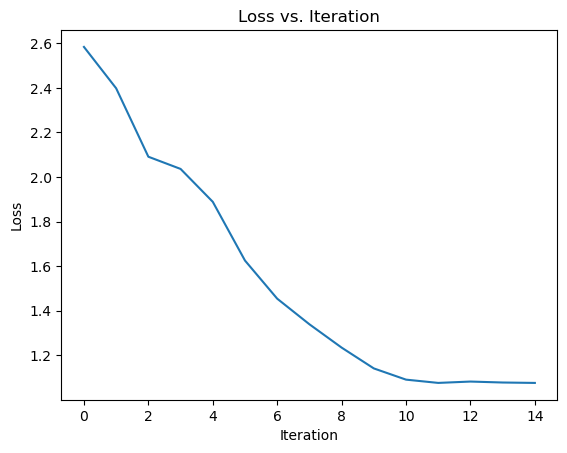

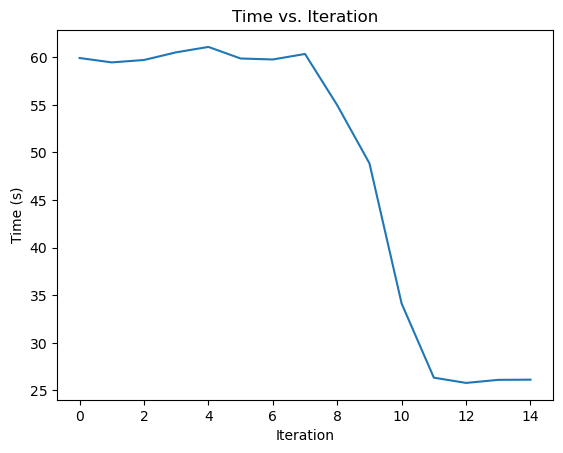

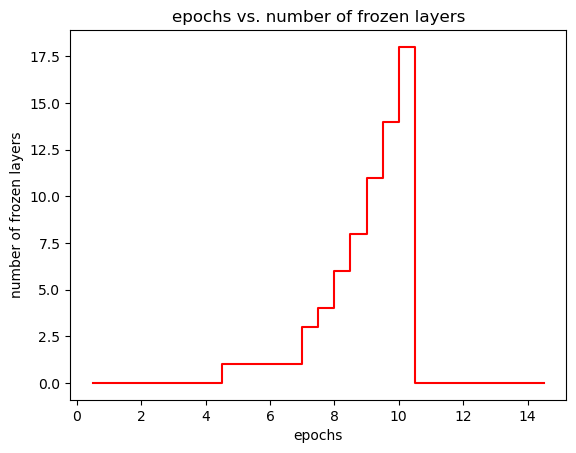

In [14]:
# 绘制损失随迭代次数变化的曲线
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()

# 绘制每次迭代的实际耗时
plt.figure()
plt.plot(times)
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Time vs. Iteration')
plt.show()
nepochs = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5]
# 绘制冻结层数随迭代次数变化的曲线
plt.figure()
plt.step(nepochs,num_layer,color='r')
plt.xlabel('epochs')
plt.ylabel('number of frozen layers')
plt.title('epochs vs. number of frozen layers')
plt.show()